In [1]:
# built on Money-generator/notebooks/random_forest.ipynb and keggle tutorial
# (1) single ticker with volume
# (2) multiple ticker as input

############# IMPORTANT #############
# Only change the parameters in 
# hash tag brackets if you are not sure
#####################################

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sqlite3 as sql
import sys
import seaborn as sns 
from scipy import stats

In [3]:
sys.path.append('../../')

from src.db_default import DB_DIR, DB_FROZEN_VARIANTS
from src.db_class import DBCursor, FinanceDB

In [4]:
db_variant_label = 'v1'
db_filename = DB_FROZEN_VARIANTS['v1']['db_filename']
finance_db = FinanceDB(db_filename)

In [1779]:
np.transpose(finance_db.get_present_tickers())

array(['AAPL', 'ADBE', 'AMZN', 'BMO.TO', 'BNS.TO', 'BRK-B', 'BTC-USD',
       'CADUSD=X', 'CM.TO', 'CNR.TO', 'COST', 'CP.TO', 'DIS', 'ENB',
       'ETH-USD', 'ETHX-B.TO', 'ETHX-U.TO', 'FB', 'GOOG', 'HUT', 'HUT.TO',
       'JPM', 'MFC', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'PG', 'RY', 'SHOP.TO',
       'SPY', 'TD.TO', 'TRI.TO', 'TSLA', 'V', 'XEC.TO', 'XEF.TO',
       'XEI.TO', 'XIC.TO', 'XUU.TO'], dtype='<U9')

# Example 1 : with volume

In [8]:
ticker = 'AAPL'
df = finance_db.get_daily_per_ticker(ticker)
df.head()

,date,open,high,low,close,adjusted_close,volume,security_ticker
0,1980-12-12 00:00:00,0.128348,0.128906,0.128348,0.128348,0.100453,469033600,AAPL
1,1980-12-15 00:00:00,0.122210,0.122210,0.121652,0.121652,0.095213,175884800,AAPL
2,1980-12-16 00:00:00,0.113281,0.113281,0.112723,0.112723,0.088224,105728000,AAPL
3,1980-12-17 00:00:00,0.115513,0.116071,0.115513,0.115513,0.090408,86441600,AAPL
4,1980-12-18 00:00:00,0.118862,0.119420,0.118862,0.118862,0.093029,73449600,AAPL


In [40]:
############ Method parameters ##########
Choose_random_forest = True #either random forrest / decision tree)

seed_1 = 0  # for random data gen
seed_2 = 0  # for train test split
seed_3 = 0  # for RandomForest classifier
seq_size = 2 # days of past data available


#feature labels:
column_choices = ['volume'] # put in features (except for 'close')

#########################################

column_choices = ['close'] + column_choices # daily rate of return is always used as a feature
assert 'close' in column_choices[0]

for column_choice in column_choices:
    assert column_choice in ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
    
feature_index = [j +' day'+str(i) for i in range(seq_size) for j in column_choices[1:]+['fractional_change']]
print('input features:' , feature_index)

input features: ['volume day0', 'fractional_change day0', 'volume day1', 'fractional_change day1']


In [41]:
use_random_data_instead_of_database = False
if use_random_data_instead_of_database:
    np.random.seed(seed_1)
    raw_data = np.random.normal(loc=1, scale=0.1, size=100000)
else:
    raw_data = df[column_choice].values
    data = df[column_choices]



close     False
volume    False
dtype: bool
      close     volume
0  0.128348  469033600
1  0.121652  175884800
2  0.112723  105728000
3  0.115513   86441600
4  0.118862   73449600


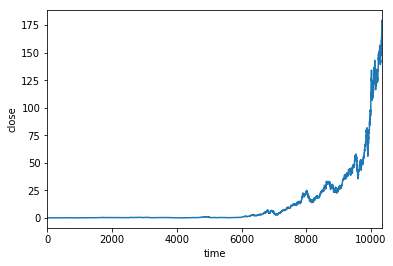

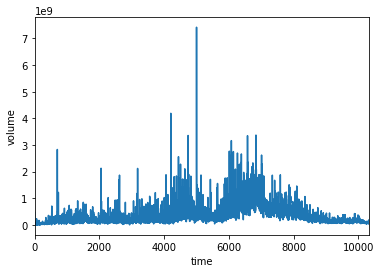

In [42]:
print(data[column_choices].isnull().any())
print(data[column_choices].head())
plt.figure()
for i in column_choices:
    plt.clf()
    data[i].plot()
    plt.xlabel('time')
    plt.ylabel(i)
    plt.show()

/Users/samlui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


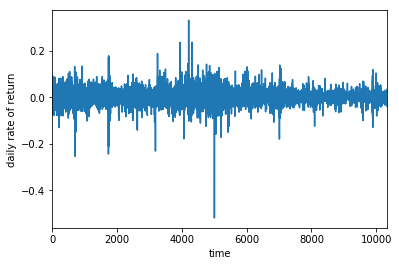

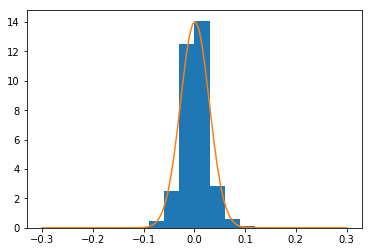

mean: 0.00111 variance: 0.00081 skew: -0.38100
P(+ve): 0.49584


In [43]:
data['fractional_change']=df['close'].pct_change() # replacing frac_diff = (raw_data[1:] - raw_data[:-1])/raw_data[:-1]
data = data.dropna(axis=0)


plt.figure()
data['fractional_change'].plot()
plt.xlabel('time')
plt.ylabel('daily rate of return')
plt.show()


plt.clf()
plt.hist(data['fractional_change'].values,bins=np.linspace(-0.3, 0.3, 21),normed=True)
plt.plot(np.linspace(-0.3, 0.3, 100), stats.norm.pdf(np.linspace(-0.3, 0.3, 100), data['fractional_change'].mean(), np.sqrt(data['fractional_change'].var())))
plt.show()
print('mean: {0:0.5f}'.format(data['fractional_change'].mean()),
      'variance: {0:0.5f}'.format(data['fractional_change'].var()), 
      'skew: {0:0.5f}'.format(data['fractional_change'].skew()))

check_prob_up = [1 if i > 0 else 0 for i in data['fractional_change'].values ]
print('P(+ve): {0:0.5f}'.format(np.sum(check_prob_up)/len(check_prob_up)))


In [44]:
# reshape dataset such that X has length = seq_size, data points non-overlapping
n_samples = data.shape[0] // (seq_size+1)
data.drop(data.tail(data.shape[0] % (seq_size+1)).index,inplace=True)
relative_data = data[column_choices[1:]+['fractional_change']].to_numpy()    
relative_data = relative_data.reshape((n_samples, (len(column_choices)*(seq_size+1))))

X = relative_data[:, :seq_size*len(column_choices)]
# should probably tidy this part up at some point. But let's use panda dataframe for the time being
X = pd.DataFrame(data=X,  columns=feature_index)
y = np.sign(relative_data[:, -1])


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_2) 
print(X_train.shape, X_test.shape)

check_prob_up = [1 if i > 0 else 0 for i in y_train ]
print('P(+ve) in train set: {0:0.5f}'.format(np.sum(check_prob_up)/len(check_prob_up)))
check_prob_up = [1 if i > 0 else 0 for i in y_test ]
print('P(+ve) in test set: {0:0.5f}'.format(np.sum(check_prob_up)/len(check_prob_up)))



(2758, 4) (690, 4)
P(+ve) in train set: 0.49166
P(+ve) in test set: 0.47536


In [46]:
# Build model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# instantiate the classifier 
####### choose parameter #####
tree_depth = 3
# tree_depth = len(feature_index) # might not be optimal, but can used in ad-hoc manner to avoid overfitting
##############################

if Choose_random_forest:
    rfc = RandomForestClassifier(max_depth = tree_depth, n_estimators=100, criterion='gini',random_state=seed_3)
else:  
    rfc = DecisionTreeClassifier(max_depth = tree_depth,random_state=seed_3)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
print('Model accuracy score with random forest : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with random forest : 0.5029


In [47]:
#Check if model is overfit
print('Training set score: {:.4f}'.format(rfc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(rfc.score(X_test, y_test)))

Training set score: 0.5468
Test set score: 0.5029


In [48]:
# important features
feature_scores = pd.Series(rfc.feature_importances_, index=feature_index).sort_values(ascending=False)
feature_scores

fractional_change day0    0.343759
fractional_change day1    0.229351
volume day1               0.215730
volume day0               0.211160
dtype: float64

/Users/samlui/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


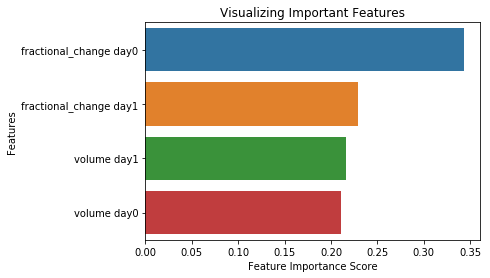

In [49]:
plt.figure()
if Choose_random_forest:
# Creating a seaborn bar plot
    sns.barplot(x=feature_scores, y=feature_scores.index)

    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
else:
    from sklearn import tree
    tree.plot_tree(rfc.fit(X_train, y_train))
    plt.tight_layout()
    plt.show()

plt.show()

Note: Need some way to normalize volume

In [50]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 89   0 248]
 [ 11   0  14]
 [ 70   0 258]]


In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.52      0.26      0.35       337
         0.0       0.00      0.00      0.00        25
         1.0       0.50      0.79      0.61       328

    accuracy                           0.50       690
   macro avg       0.34      0.35      0.32       690
weighted avg       0.49      0.50      0.46       690



/Users/samlui/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samlui/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samlui/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Example 2

In [52]:
other_tickers = ['ADBE','COST',  'DIS', 'ENB','JPM', 'MSFT',   'PFE', 'PG']
target_ticker = ['AAPL']
ticker = other_tickers + target_ticker
test_data = finance_db.get_daily_per_ticker(ticker[0])[['date','close']].set_index('date')
for i in ticker[1:]:
    test_data = test_data.join(finance_db.get_daily_per_ticker(i)[['date','close']].set_index('date'),how='inner',rsuffix='_'+i)
test_data.head()

,close,close_COST,close_DIS,close_ENB,close_JPM,close_MSFT,close_PFE,close_PG,close_AAPL
date,,,,,,,,,
1986-08-13 00:00:00,0.210938,9.6875,3.925448,2.150579,15.708333,0.103299,2.782060,4.789063,0.160714
1986-08-14 00:00:00,0.222656,9.5000,3.832964,2.160094,15.750000,0.105903,2.782060,4.773438,0.160714
1986-08-15 00:00:00,0.218750,9.3750,3.802135,2.112515,15.833333,0.106337,2.772177,4.843750,0.159598
1986-08-18 00:00:00,0.210938,9.6875,3.761031,2.112515,15.833333,0.105035,2.752411,4.929688,0.157924
1986-08-19 00:00:00,0.214844,9.5625,3.699375,2.112515,16.083332,0.105035,2.717821,4.890625,0.157924


In [53]:
raw_data = test_data.pct_change()
raw_data = raw_data.dropna(axis=0)
raw_data.head()

,close,close_COST,close_DIS,close_ENB,close_JPM,close_MSFT,close_PFE,close_PG,close_AAPL
date,,,,,,,,,
1986-08-14 00:00:00,0.055552,-0.019355,-0.023560,0.004424,0.002653,0.025208,0.000000,-0.003263,0.000000
1986-08-15 00:00:00,-0.017543,-0.013158,-0.008043,-0.022026,0.005291,0.004098,-0.003552,0.014730,-0.006944
1986-08-18 00:00:00,-0.035712,0.033333,-0.010811,0.000000,0.000000,-0.012244,-0.007130,0.017742,-0.010489
1986-08-19 00:00:00,0.018517,-0.012903,-0.016393,0.000000,0.015789,0.000000,-0.012567,-0.007924,0.000000
1986-08-20 00:00:00,0.000000,-0.006536,0.022222,0.000000,0.010363,-0.008264,-0.003636,-0.012780,0.024733


In [54]:
# reshape dataset such that X has length = seq_size, data points non-overlapping
data = raw_data
seq_size = 2
feature_index = [j +' day'+str(i) for i in range(seq_size) for j in ticker]
print('input features:' , feature_index)
n_samples = data.shape[0] // (seq_size+1)
data.drop(data.tail(data.shape[0] % (seq_size+1)).index,inplace=True)
relative_data = data.to_numpy()    
relative_data = relative_data.reshape((n_samples, (len(ticker)*(seq_size+1))))

X = relative_data[:, :seq_size*len(ticker)]
# should probably tidy this part up at some point. But let's use panda dataframe for the time being
X = pd.DataFrame(data=X,  columns=feature_index)
y = np.sign(relative_data[:, -1])


input features: ['ADBE day0', 'COST day0', 'DIS day0', 'ENB day0', 'JPM day0', 'MSFT day0', 'PFE day0', 'PG day0', 'AAPL day0', 'ADBE day1', 'COST day1', 'DIS day1', 'ENB day1', 'JPM day1', 'MSFT day1', 'PFE day1', 'PG day1', 'AAPL day1']


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_2) 
print(X_train.shape, X_test.shape)

check_prob_up = [1 if i > 0 else 0 for i in y_train ]
print('P(+ve) in train set: {0:0.5f}'.format(np.sum(check_prob_up)/len(check_prob_up)))
check_prob_up = [1 if i > 0 else 0 for i in y_test ]
print('P(+ve) in test set: {0:0.5f}'.format(np.sum(check_prob_up)/len(check_prob_up)))



(2376, 18) (594, 18)
P(+ve) in train set: 0.50168
P(+ve) in test set: 0.52525


In [64]:
# Build model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# instantiate the classifier 
####### choose parameter #####
Choose_random_forest = True #either random forrest / decision tree)
tree_depth = 2
# tree_depth = len(feature_index) # might not be optimal, but can used in ad-hoc manner to avoid overfitting
##############################

if Choose_random_forest:
    rfc = RandomForestClassifier(max_depth = tree_depth, n_estimators=100, criterion='gini',random_state=seed_3)
else:  
    rfc = DecisionTreeClassifier(max_depth = tree_depth,random_state=seed_3)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
print('Model accuracy score with random forest : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with random forest : 0.5438


In [65]:
#Check if model is overfit
print('Training set score: {:.4f}'.format(rfc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(rfc.score(X_test, y_test)))

Training set score: 0.5429
Test set score: 0.5438


PG day1      0.111601
ADBE day0    0.097988
ENB day0     0.083494
PFE day1     0.068398
ADBE day1    0.062443
COST day1    0.060535
DIS day1     0.060498
COST day0    0.055297
ENB day1     0.054244
AAPL day1    0.051629
JPM day1     0.044583
JPM day0     0.041592
MSFT day1    0.040085
DIS day0     0.037272
PG day0      0.035114
PFE day0     0.033177
MSFT day0    0.032547
AAPL day0    0.029505
dtype: float64


/Users/samlui/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


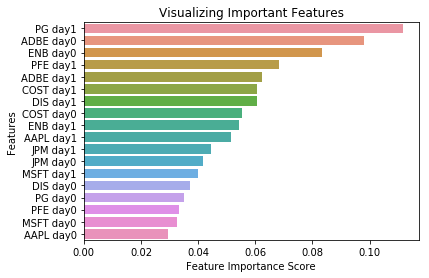

In [66]:
# important features
feature_scores = pd.Series(rfc.feature_importances_, index=feature_index).sort_values(ascending=False)
print(feature_scores)

plt.figure()
if Choose_random_forest:
# Creating a seaborn bar plot
    sns.barplot(x=feature_scores, y=feature_scores.index)

    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
else:
    from sklearn import tree
    tree.plot_tree(rfc.fit(X_train, y_train))
    plt.tight_layout()
    plt.show()

plt.show()

In [67]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 26   0 240]
 [  4   0  12]
 [ 15   0 297]]


In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.58      0.10      0.17       266
         0.0       0.00      0.00      0.00        16
         1.0       0.54      0.95      0.69       312

    accuracy                           0.54       594
   macro avg       0.37      0.35      0.29       594
weighted avg       0.54      0.54      0.44       594



/Users/samlui/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samlui/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/samlui/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Change Choose_random_forest to True for intuition. Basically, the decision is always to choose +ve